## Imports

In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Add # layers used in model
from tensorflow.keras.utils import plot_model # see model architecture
from tensorflow.keras.optimizers import Adam
from wandb.keras import WandbCallback
from PIL import Image # load 'em image files
import tensorflow.keras.backend as K # getting/setting the weights for the VGG feature extractor
import matplotlib.pyplot as plt # plotting utilities
import tensorflow.keras.applications as kapp # VGG19 utilities
import tensorflow as tf # more math-focused operations like ReLU
import numpy as np # linear algebra
import random
import wandb
import time
import glob # getting complete input filepaths for building the dataset 
import os # basic file navigation

from kaggle_secrets import UserSecretsClient
secret_label = "wab_key"
os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret(secret_label)

#wandb.init(project="mongoly_sweep", entity="tiewa_enguin", name='pyramidal_32_vgg_3')
wandb.init(project="mongoly_sweep", entity="tiewa_enguin", name='base_config_lr_1e-3')

wandb: Currently logged in as: tiewa_enguin (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Hyperparameters

In [2]:
BATCH_SIZE = 32
EPOCHS = 3
CV_RATIO = 0.9 # proportion of the full dataset reserved for training, the rest is validation
FULL_IMG_SIZE = (720, 1280) # size of the input images as well as the images that we want to test our model's speed on
IMG_SIZE = (256, 256) # the size of the images used during training; we will take random crops of the full-sized (720p) imagees
DEG_DIR = '/kaggle/input/video-frame-restoration/deg' # parent path of the degraded input images
GT_DIR = '/kaggle/input/video-frame-restoration/gt' # parent path of the ground truth (GT) images

## Get File Paths For Dataset

In [3]:
# get all of the input images
# 1st * = get folders with h264 and vp9 compression
# 2nd * = get folders from all compression qualities
# 3rd * = get all files from the folders collected from the 1st and 2nd stars
input_img_paths = sorted(glob.glob(f'{DEG_DIR}/*/*/*'))

# get all of the output images
target_img_paths = sorted(glob.glob(f'{GT_DIR}/*'))

m = len(target_img_paths) # the number of unique images in the dataset (the input data contains a multiple of this amount)
train_m = int(m * CV_RATIO) # the number of unique training images
num_copies = len(input_img_paths) // m # returns the number of compression types and scales were used to synthesize the input data from the target data

for i in range(10): # list first 10 input/target file paths
    print(f'Input image path: {input_img_paths[i]} | Target image path: {target_img_paths[i]}')
    
print("Number of input images:", len(input_img_paths))
print("Number of target images:", len(target_img_paths))

Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00001.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00000.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00002.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00001.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00003.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00002.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00004.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00003.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00005.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00004.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00006.jpg | Target image path: /kaggle/input/video-frame-restoration/gt/00005.jpg
Input image path: /kaggle/input/video-frame-restoration/deg/h264/crf_3/00007.jpg |

### View Some Input Images

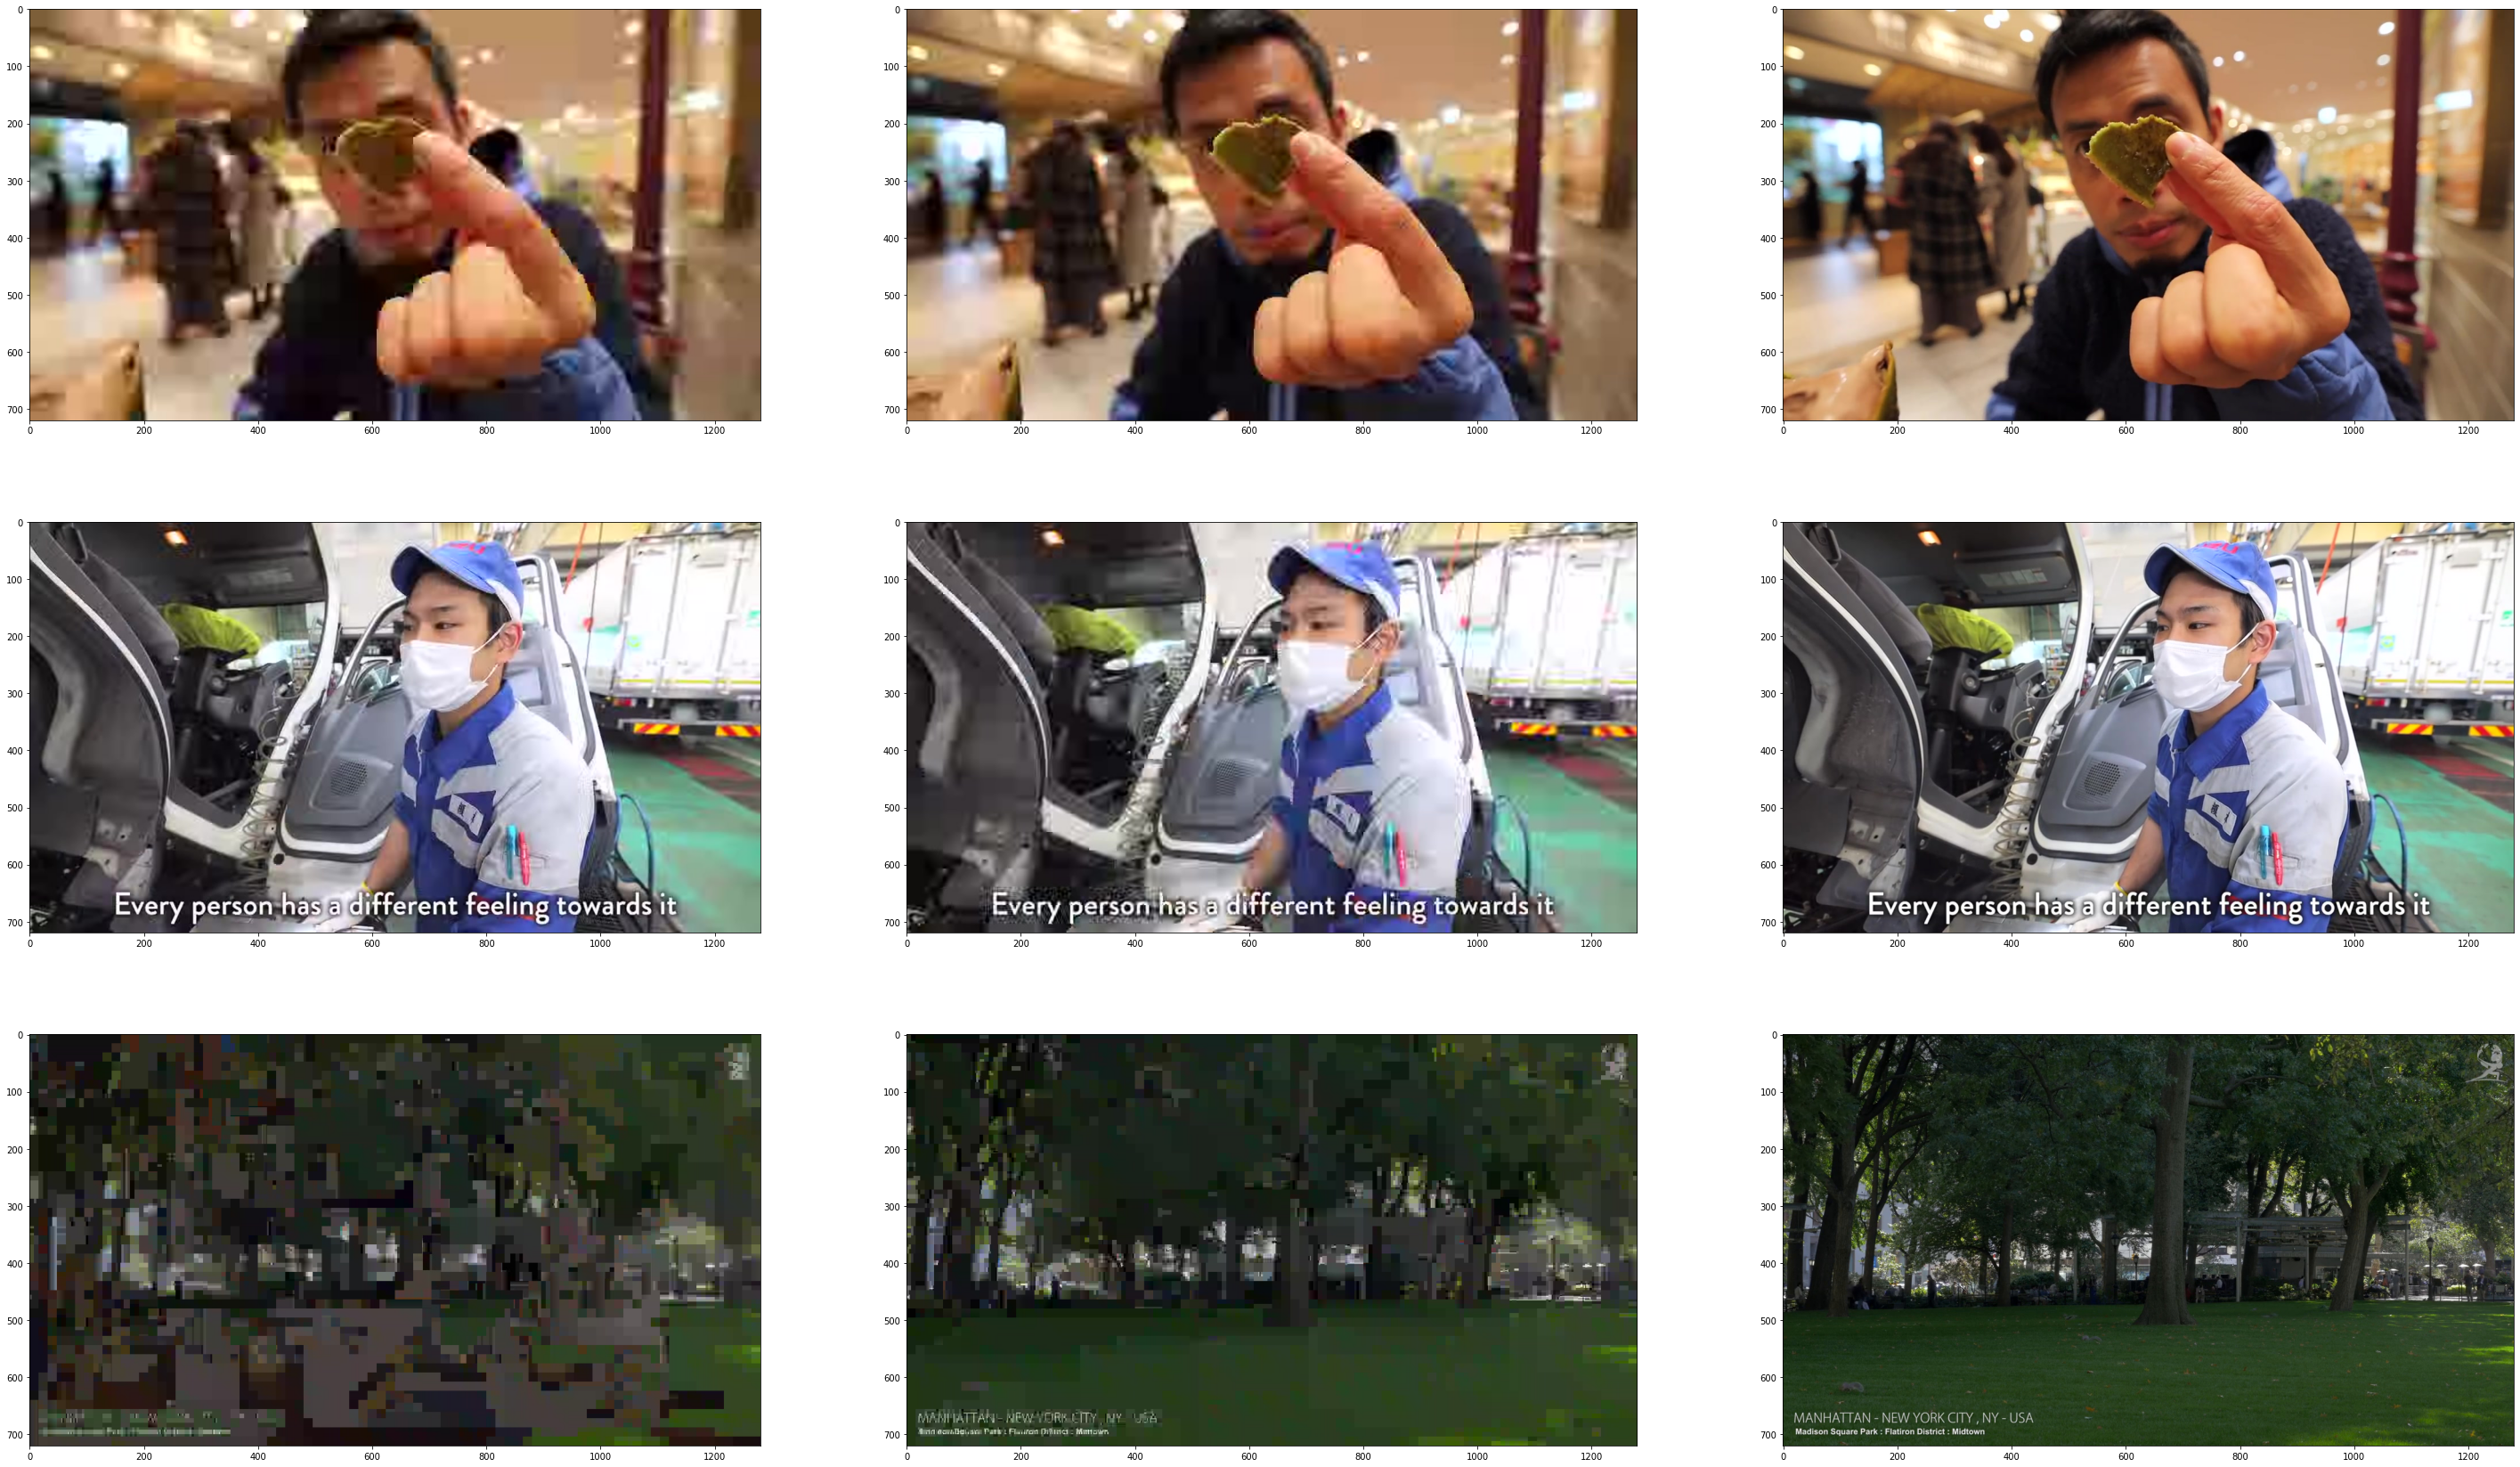

In [4]:
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(50, 30)) # 3 rows and 7 columns of images to be viewed
for row in range(rows):
    seed_image_idx = random.randint(0, m-1) # index of ground truth image which will be displayed
    input_image_idxs = np.random.choice([i for i in range(6)], cols-1, replace=False) # choose cols-1 random augmentations from the 6 made in the dataset
    for col, input_image_idx in enumerate(input_image_idxs): # first 6 columns in each row shows the same input image with different compressions, last column shows the ground truth image
        img = Image.open(input_img_paths[input_image_idx * m + seed_image_idx]) # the way the dataset is formatted allows the same input images to be accessed like this
        axes[row][col].imshow(img)
    gt_img = img = Image.open(target_img_paths[seed_image_idx])
    axes[row][-1].imshow(gt_img)
plt.show()

## Split Input/Output Images Into Train/Validation Datasets

In [5]:
train_input_paths = []
val_input_paths = []

for i in range(num_copies):
    # get start, end, and split indexes for each [section] of images
    s_i = m * i
    split_i = s_i + train_m
    e_i = s_i + m
    
    # update the train and validation dataset based on the indexes defined above
    train_input_paths += input_img_paths[s_i:split_i]
    val_input_paths += input_img_paths[split_i:e_i]

# split the ground truth images into train/validation
train_gt_paths = target_img_paths[:train_m]
val_gt_paths = target_img_paths[train_m:]

# replicate the target data to be the same size as the training data
train_gt_paths *= num_copies
val_gt_paths *= num_copies
assert len(train_gt_paths) - len(train_input_paths) == len(val_gt_paths) - len(val_input_paths) == 0 # make sure the datasets are the same length

# shuffle the train/validation datasets such that the train and the target data are shuffled together (so an index accesses an input as well as its corresponding output)
zipped_paths = list(zip(train_input_paths, train_gt_paths))
random.shuffle(zipped_paths)
train_input_paths, train_gt_paths = zip(*zipped_paths)

zipped_paths = list(zip(val_input_paths, val_gt_paths))
random.shuffle(zipped_paths)
val_input_paths, val_gt_paths = zip(*zipped_paths)

## Dataset Class

In [6]:
class ImgDataset(tf.keras.utils.Sequence): # seed code by hhttps://keras.io/examples/vision/oxford_pets_image_segmentation/, modified to perform minor data augmentation
    def __init__(self, input_img_paths, target_img_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
        self.batch_size = batch_size
        self.imgs_per_batch = batch_size // 8 # number of images to load from disk per batch, as each image from disk will be used to make 8 training images
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.imgs_per_batch

    def __getitem__(self, idx):
        s_i = idx * self.imgs_per_batch # get the start index for loading the correct image paths for the specific batch index
        batch_input_img_paths = self.input_img_paths[s_i: s_i + self.imgs_per_batch]
        batch_target_img_paths = self.target_img_paths[s_i: s_i + self.imgs_per_batch]
        
        x = np.zeros((self.batch_size, *self.img_size, 3), np.float32) # return arrays for the input/output images
        y = np.array(x, copy=True)
        
        # random augmentation parameters for the batch, must be applied to the input and target image in the same way
        
        # each loaded image will be FULL_IMG_SIZE dimensions but we need to crop to IMG_SIZE dimensions so set the sampling bounds accordingly
        random_crop_y = np.random.uniform(0, FULL_IMG_SIZE[0]-IMG_SIZE[0], (self.batch_size,)).astype(np.int32)
        random_crop_x = np.random.uniform(0, FULL_IMG_SIZE[1]-IMG_SIZE[1], (self.batch_size,)).astype(np.int32)
        x_flip = np.random.uniform(0, 2, (self.batch_size,)).astype(np.int32) # 0 = no flip, 1 = flip
        rotations = np.random.uniform(0, 4, (self.batch_size,)).astype(np.int32) # 0-3 inclusive, represents the amount of 90 degree flips
        
        # load the images from disk, do some data augmentation, place the augmented data into the buffers
        for input_paths, buffer in ((batch_input_img_paths, x), (batch_target_img_paths, y)):
            for i, path in enumerate(input_paths):
                img = np.array(Image.open(path))
                for k in range(8): # augment the loaded image 8 times
                    aug_idx = i*8 + k
                    aug_img = img[ # random crop
                        random_crop_y[aug_idx]:random_crop_y[aug_idx]+IMG_SIZE[0],
                        random_crop_x[aug_idx]:random_crop_x[aug_idx]+IMG_SIZE[1]]
                    aug_img = tf.image.rot90(aug_img, k=rotations[aug_idx]) # random rotation
                    if x_flip[aug_idx] == 1: # random x flip
                        aug_img = aug_img[:, ::-1]
                    buffer[aug_idx] = aug_img # store data
            buffer /= 255.0 # normalize data from [0, 255] to [0, 1) for easier model training
        return x, y

## Generator architecture

In [7]:
def gen_gen():
    inputs = Input(shape=(None, None, 3)) # (None, None) means images of any size can be placed in the model (as long as it has 3 channels)
    
    up_nf = [32, 128] # number of channels for each upscaling level
    x = Conv2D(up_nf[0]//4, 1, padding="same")(inputs)

    downs = []
    for out_f in up_nf: # downscaling image (via strided convolutions) to distill better representations of the image
        downs.append(x)
        x = Conv2D(out_f, 5, strides=2, padding="same", activation='relu')(x) # kernel size of 5 allows all pixels to be equally represented in the stride-2 convolution
            
    for i in range(0):
        skip = x # residual blocks instantly make your model better
        x = Conv2D(out_f, 3, padding="same", activation='relu')(x)
        x = Conv2D(out_f, 3, padding="same", activation='relu')(x)
        x = Add()([x, skip])
            
    for idx, in_f in enumerate(up_nf[::-1]): # upscaling blocks
        out_f = in_f // 4 # you have to do some weird channel/image size magic to get U-Nets to work, but it is what it is
        x = UpSampling2D()(x) # expand the image size from HxW to 2Hx2W
        x = Conv2D(out_f, 1, padding="same")(x) # 1x1 convolution used to change the channel size of the image tensor
        x = Add()([x, downs[-idx-1]]) # it isn't really a U-Net without some concatenations (I'm using residuals because it's faster)
        
        skip = x # residual blocks instantly make your model better
        x = Conv2D(out_f, 3, padding="same", activation='relu')(x)
        x = Conv2D(out_f, 3, padding="same", activation='relu')(x)
        x = Add()([x, skip])

    outputs = Conv2D(3, 1, padding="same")(x) # final convolution with 3 channels representing the 3 color channels for RGB 

    model = Model(inputs, outputs) # wrap it all up into a Model so it can be called
    return model

## VGG Feature Extractor Architecture

In [8]:
# corresponds to conv_1_2, conv_2_2, conv_3_4, conv_4_4, conv_5_4 (conv_a_b represents the b-th convolution before the a-th max pooling layer)
vgg_layer_idxs = [2, 5, 10, 15, 20]
mbv2_layer_idxs = [8, 26, 53, 115, 150]

def gen_vgg_extractor():
    vgg = kapp.VGG19(
        include_top=False,
        input_shape=(None, None, 3)
    )
    
    outputs = []
    
    for layer_idx in vgg_layer_idxs:
        # get info from the layer's parameters
        layer_kernel = K.get_value(vgg.layers[layer_idx].kernel)
        layer_bias = K.get_value(vgg.layers[layer_idx].bias)
        layer_output_fmaps = layer_kernel.shape[-1] # o in kkio
        layer_output_kernel_shape = layer_kernel.shape[0] # k in kkio
        
        # create a deep copy of the layer which we want to extract, but specify no activation
        extracted_layer = Conv2D(layer_output_fmaps, layer_output_kernel_shape, padding='same', activation='linear')
        extracted_layer(vgg.layers[layer_idx-1].output) # build the layer weights by calling it so it doesn't get reinitialized witih random values during training
        
        # set the weights of the randomly initialized layer to be that of the pretrained network
        K.set_value(extracted_layer.kernel, layer_kernel)
        K.set_value(extracted_layer.bias, layer_bias)
        
        outputs.append(tf.cast(extracted_layer(vgg.layers[layer_idx-1].output), 'float32')) # set the feature map to be an output of the model
    
    vgg_extractor = Model(vgg.input, outputs, name='vgg_extractor')
    vgg_extractor.trainable = False
    
    return vgg_extractor

def gen_mbv2_extractor():
    mbv2 = kapp.MobileNetV2(
        include_top=False,
        input_shape=(None, None, 3)
    )
    
    outputs = []
    
    for layer_idx in mbv2_layer_idxs:
        outputs.append(tf.cast(mbv2.layers[layer_idx].output, 'float32')) # set the feature map to be an output of the model
    
    mbv2_extractor = Model(vgg.input, outputs, name='mbv2_extractor')
    mbv2_extractor.trainable = False
    
    return mbv2_extractor

### Generator FPS Test

In [9]:
def test_fps(duration=60):
    test_img = np.zeros((1, *FULL_IMG_SIZE, 3), dtype='float32') # test the FPS of the model on a full 720p image since that is the image size for the intended use case 
    gen(test_img) # TF calls a lot of functions on just the first call of a model so we don't want to include the time for that in our FPS test
    a = time.time() # start the clock
    frames = 0
    while time.time() - a < duration:
        gen(test_img)
        frames += 1
    return frames / duration

## Loss Functions

In [10]:
def gram_matrix(features):
    H = tf.shape(features)[1]
    W = tf.shape(features)[2]
    C = tf.shape(features)[3]
    features = tf.reshape(features, [-1, H * W, C])

    gram_matrix = tf.matmul(features, features, transpose_a=True)
    normalized_gram_matrix = gram_matrix / tf.cast(H * W * C, 'float32')

    return normalized_gram_matrix

def texture_loss_fn(features, patch_size=32): # style loss, patch size refers to the size of the image patches where the Gram matrices are calculated
    H = tf.shape(features)[1]
    W = tf.shape(features)[2]
    C = tf.shape(features)[3]
    
    # split image tensor into patch_size x patch_size sized feature maps
    features = tf.space_to_batch_nd(features, [patch_size, patch_size], [[0, 0], [0, 0]])
    features = tf.reshape(features, [patch_size, patch_size, -1, H // patch_size, W // patch_size, C])
    features = tf.transpose(features, [2, 3, 4, 0, 1, 5])
    patches_gt, patches_pred = tf.split(features, 2, axis=0)

    patches_gt = tf.reshape(patches_gt, [-1, patch_size, patch_size, C])
    patches_pred = tf.reshape(patches_pred, [-1, patch_size, patch_size, C])

    # get them gram matrices
    gram_matrix_gt = gram_matrix(patches_gt)
    gram_matrix_pred = gram_matrix(patches_pred)

    tl_features = tf.reduce_mean(tf.square(gram_matrix_gt - gram_matrix_pred)) # find the L2 loss between the gram matrices
    return tl_features

mae = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.abs(y_pred - y_true)) # L1 loss = mean absolute error (MAE)
def vgg_loss_fn(y_true, y_pred, vgg_weight=1e-1, texture_weight=2e-6):
    # Keras VGG-19 requires images with ranges [0, 255] to be placed into a preprocessing function which can then be passed into the model
    y_true_preprocessed = kapp.vgg19.preprocess_input(y_true * 255) # [0, 1) * 255 = [0, 255]
    y_pred_preprocessed = kapp.vgg19.preprocess_input(y_pred * 255)
    
    # pass the preprocessed images into the VGG feature extractor
    gt12, gt22, gt34, gt44, gt54 = vgg(y_true_preprocessed)
    p12, p22, p34, p44, p54 = vgg(y_pred_preprocessed)
    cat12, cat22, cat34 = tf.concat([gt12, p12], 0), tf.concat([gt22, p22], 0), tf.concat([gt34, p34], 0) # concatenate feature maps for the texture loss function
    
    # Real-ESRGAN content loss
    vgg_loss = sum((
        0.1 * mae(gt12, p12),
        0.1 * mae(gt22, p22),
        mae(gt34, p34),
        mae(gt44, p44),
        mae(gt54, p54),
    ))
    
    # EnhanceNet style loss
    texture_loss = sum((
        0.3 * texture_loss_fn(cat12),
        texture_loss_fn(cat22),
        texture_loss_fn(cat34),
    ))
    
    return vgg_loss * vgg_weight + texture_loss * texture_weight

def mbv2_loss_fn(y_true, y_pred):
    # Keras VGG-19 requires images with ranges [0, 255] to be placed into a preprocessing function which can then be passed into the model
    y_true_preprocessed = kapp.mobilenet_v2.preprocess_input(y_true * 255) # [0, 1) * 255 = [0, 255]
    y_pred_preprocessed = kapp.mobilenet_v2.preprocess_input(y_pred * 255)
    
    # pass the preprocessed images into the VGG feature extractor
    gt1, gt2, gt3, gt4, gt5 = mbv2(y_true_preprocessed)
    p1, p2, p3, p4, p5 = mbv2(y_pred_preprocessed)
    
    # Real-ESRGAN content loss
    percep_loss = sum((
        0.1 * mae(gt1, p1),
        0.1 * mae(gt2, p2),
        mae(gt3, p3),
        mae(gt4, p4),
        mae(gt5, p5),
    ))
    return percep_loss

### Build Datasets and Models

In [11]:
train_gen = ImgDataset(
    train_input_paths, train_gt_paths
)
val_gen = ImgDataset(val_input_paths, val_gt_paths)

In [12]:
gen = gen_gen()
vgg = gen_vgg_extractor()
mbv2 = gen_mbv2_extractor()
gen.summary()

2022-01-15 02:43:01.708834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 02:43:01.793649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 02:43:01.794354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 02:43:01.796087: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 8 32          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 6432        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 1 102528      conv2d_1[0][0]                   
_____________________________

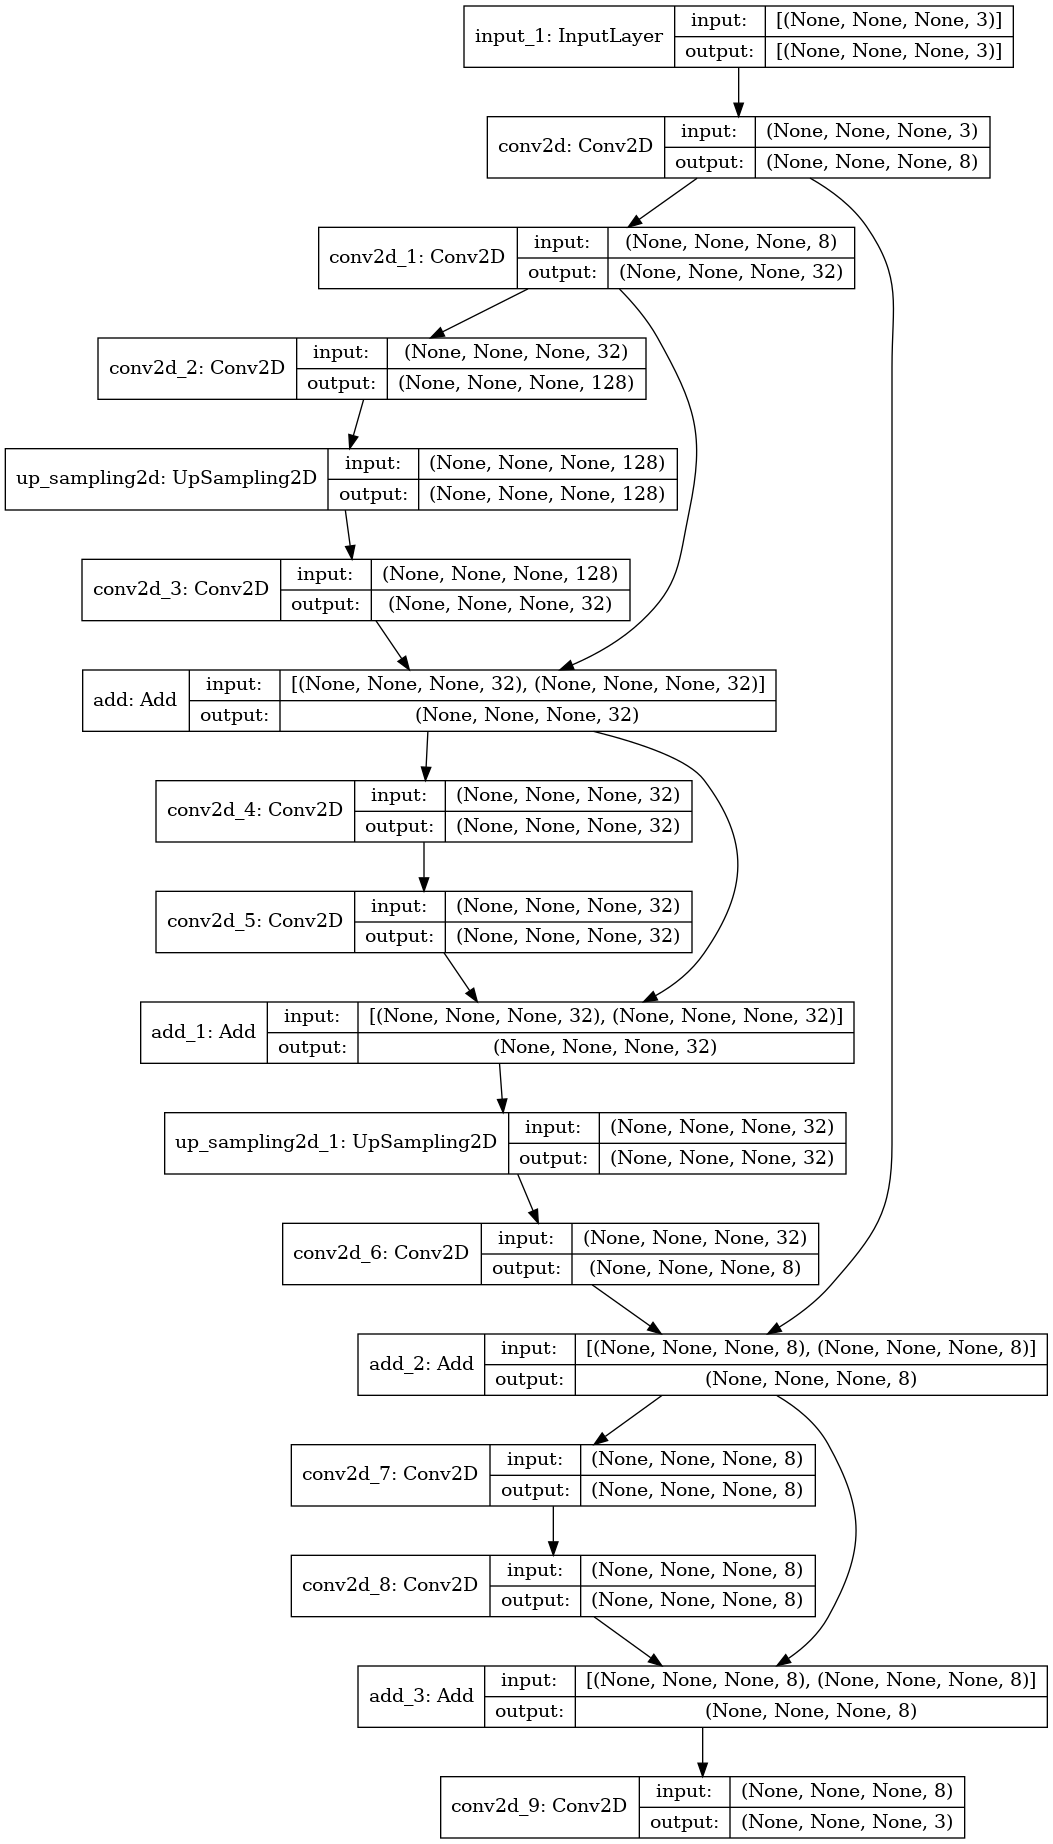

In [13]:
plot_model(gen, to_file="gen_architecture.png", show_shapes=True)

In [14]:
fps = test_fps()
print(f'Model ran at {fps} FPS')

2022-01-15 02:43:07.278449: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Model ran at 55.833333333333336 FPS


### Compile Models

In [15]:
# A lot of image generation papers (like StyleGAN, SRGAN, and ESRGAN) tend to use Adam optimizers at similar learning rates
gen_opt = Adam(1e-3)gen.compile(optimizer=gen_opt, loss=vgg_loss_fn) # Yes, we can compile with custom loss functions!
#gen.compile(optimizer=gen_opt, loss=mbv2_loss_fn) # Yes, we can compile with custom loss functions!

## Train the Model

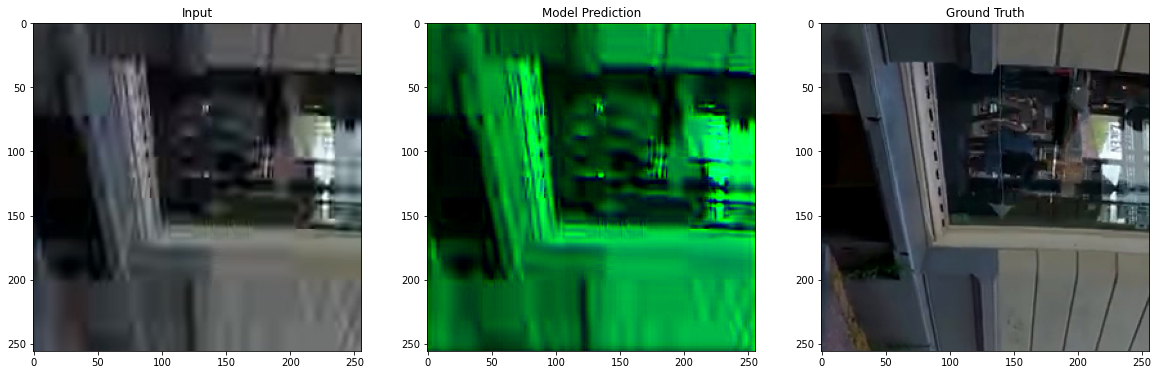

Image loss: 233.28457641601562


2022-01-15 02:44:13.322351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4745/7957 [================>.............] - ETA: 57:20 - loss: 75.5802

In [ ]:
for epoch in range(EPOCHS):
    # view validation data predictions each epoch
    fig, axes = plt.subplots(1, 3, figsize=(20, 40))
    test_deg_batch, test_gt_batch = random.choice(val_gen)
    test_deg_img, test_gt_img = test_deg_batch[:1], test_gt_batch[:1]
    pred = gen(test_deg_img)
    axes[0].imshow(test_deg_img[0])
    axes[0].set_title('Input')
    axes[1].imshow(pred[0])
    axes[1].set_title('Model Prediction')
    axes[2].imshow(test_gt_img[0])
    axes[2].set_title('Ground Truth')
    plt.show()
    print(f'Image loss: {gen_loss(test_gt_img, pred)}')

    gen.fit(train_gen, validation_data=val_gen, callbacks=[WandbCallback()]) # train

## Model Evaluation

In [ ]:
gen.evaluate(val_gen)

## Generator Prediction Visualization

In [ ]:
rows = 3
fig, axes = plt.subplots(rows, 3, figsize=(20, 20))

for row in range(rows):
    test_deg_batch, test_gt_batch = random.choice(val_gen)
    test_deg_img, test_gt_img = test_deg_batch[:1], test_gt_batch[:1]
    pred = gen(test_deg_img)
    axes[row][0].imshow(test_deg_img[0])
    axes[row][0].set_title('Input')
    axes[row][1].imshow(pred[0])
    axes[row][1].set_title('Model Prediction')
    axes[row][2].imshow(test_gt_img[0])
    axes[row][2].set_title('Ground Truth')
plt.show()

That's not too bad! Let's save our model so we can use it later.

In [ ]:
gen.save('/kaggle/working/gen_430K')

# zip the folder using Unix command-line utilities
%cd /kaggle/working # equivalent to os.chdir('/kaggle/working') but much more concise
!zip -r gen_430K.zip gen_430K # use ! to run a command-line program, the -r stands for "recursive" and zips the gen_430K folder 

## How to Load This Model
Since our model was compiled with a custom loss, TF will freak out if you don't define the custom loss when loading the model.

In [ ]:
# for future model training
gen = load_model('/kaggle/working/gen_430K', custom_objects={'gen_loss': gen_loss}) # you can theoretically change this loss function to be another kind for training

# for inference (no more training)
gen = load_model('/kaggle/working/gen_430K', custom_objects={'gen_loss': None}) # we don't care about training loss functions if we're not going to train the model

## You've made it to the end!
Hopefully you learned something new from this notebook. For further modifications to this notebook, you could:
- Deploy this model on a device like an Edge TPU (this model was intended to run on an Edge TPU, by the way)
- Scale the model up to have a slower model but with better performance
- Change the data augmentation procedure and add custom data for your needs
- Train this model for longer to see what results you can get out
- Add a discriminator and use adversarial training to generate even more realistic looking textures (https://arxiv.org/pdf/1809.00219.pdf)
- Take sections from this code and reuse them in completely different programs